In [1]:
from pyparticle.population import build_population
import numpy as np 
#fixed_RI = [1.75, 0.44]
#fixed_RI = 1.75 + 0.44j
fixed_RI = 1.45 + 0.j
species_modifications = {'SO4':{'n_550': np.real(fixed_RI), 'k_550': np.imag(fixed_RI), 'alpha_n': 0.0, 'alpha_k': 0.0}}
pop_cfg_50nm = {
    "type": "binned_lognormals",
    "N": [1e7],
    #"N_units": "m-3",
    "GMD": [50e-9],
    #"GMD_units": "m",
    "GSD": [1.6],
    "aero_spec_names": [["SO4"]],
    "aero_spec_fracs": [[1.0]],
    "N_bins": 1000,
    "D_min": 1e-10,
    "D_max": 1e-2,
    #"refractive_index": fixed_RI,
    'species_modifications': species_modifications,#{'SO4':{'n_550': np.real(fixed_RI), 'k_550': np.imag(fixed_RI), 'alpha_n': 0.0, 'alpha_k': 0.0}},
  }
pop_cfg_100nm = pop_cfg_50nm.copy()
pop_cfg_100nm["GMD"] = [100e-9]

pop_cfg_200nm = pop_cfg_50nm.copy()
pop_cfg_200nm["GMD"] = [200e-9]

pop_configs = [pop_cfg_50nm, pop_cfg_100nm, pop_cfg_200nm]
pop_50nm = build_population(pop_cfg_50nm)
pop_100nm = build_population(pop_cfg_100nm)
pop_200nm = build_population(pop_cfg_200nm)




ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/fier887/miniforge3/envs/pyparticle3/lib/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/fier887/miniforge3/envs/pyparticle3/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/Users/fier887/miniforge3/envs/pyparticle3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/Users/fier887/miniforge3/envs/pyparticle3/lib/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/Users/fier887/miniforge3/envs/pyparticle3/lib/python3.9/site-packages/traitlets/t

FileNotFoundError: aero_data.dat not found. Set PYPARTICLE_DATA_PATH to your datasets root or ensure the package includes datasets/species_data/aero_data.dat.

In [ ]:
from pyparticle.viz.style import StyleManager, Theme
from pyparticle.viz.builder import build_plotter
mgr = StyleManager(Theme(), deterministic=True)

# Canonical series: each entry must provide a pop_cfg dict and a human label
series = [
    {"label": "$\mu=50$ nm",  "pop_cfg": pop_cfg_50nm},
    {"label": "$\mu=100$ nm", "pop_cfg": pop_cfg_100nm},
    {"label": "$\mu=200$ nm", "pop_cfg": pop_cfg_200nm},
]
# Derive simple keys for style manager from labels (short sanitized keys)
keys = [str(i) for i in range(len(series))]
line_styles = mgr.plan("line", keys)

import matplotlib.pyplot as plt


Replaced examples/helpers call with adapter at `PyParticle.adapters.pymiescatt_ref`; you can delete the old `helpers/pymiescatt_comparison` when ready.

In [ ]:
# Helper: validate pop_cfgs used by this notebook
def _validate_pop_cfg(pop_cfg):
    if not isinstance(pop_cfg, dict):
        raise TypeError('pop_cfg must be a dict')
    required = ['type', 'GMD', 'GSD', 'N_bins']
    missing = [k for k in required if k not in pop_cfg]
    if missing:
        raise ValueError(f'pop_cfg missing required keys: {missing}')
    if 'D_min' in pop_cfg and 'D_max' in pop_cfg and pop_cfg['D_min'] >= pop_cfg['D_max']:
        raise ValueError('pop_cfg D_min must be < D_max')
    if pop_cfg.get('N_bins', 0) > 5000:
        import warnings; warnings.warn('N_bins > 5000 may be slow in notebooks')
    return True


/Users/fier887/Library/CloudStorage/OneDrive-PNNL/Code/PyParticle/src/PyParticle/aerosol_particle.py:262: UserWarning: Surface tension not implemented; returning default 0.072 N/m
  warnings.warn("Surface tension not implemented; returning default 0.072 N/m", UserWarning)


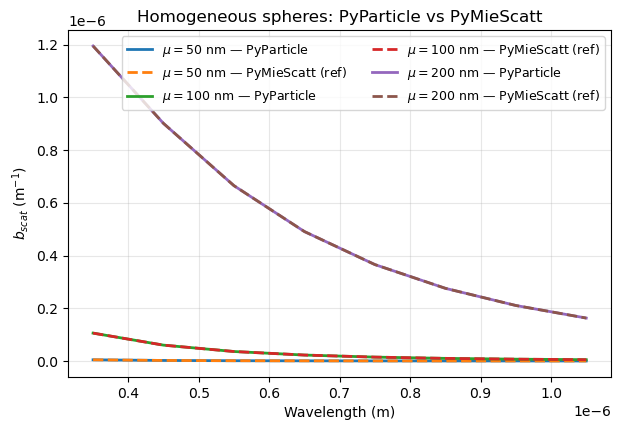

In [ ]:
# Compare PyParticle b_scat against a PyMieScatt reference via the shared adapter
import numpy as np
import matplotlib.pyplot as plt

from pyparticle.population.builder import build_population
from pyparticle.analysis.population.factory import b_scat as _bscat
from pyparticle.adapters.pymiescatt_ref import pymiescatt_lognormal_optics  # returns (wvl_nm, b_scat_m, b_abs_m)

# --- Grids (meters) ---
wvl_grid = np.linspace(350e-9,1050e-9,8)
rh_grid  = [0.0]

fig, ax = plt.subplots(figsize=(7, 4.5))

for item in series:
    pop_cfg = item['pop_cfg']
    label = item['label']
    # validate canonical pop_cfg
    _validate_pop_cfg(pop_cfg)
    # Build population from the canonical config inside the loop
    pop = build_population(pop_cfg)
    # PyParticle b_scat on the same grid as the adapter
    var_cfg = {
        'morphology': 'homogeneous',
        'rh_grid': rh_grid,
        'wvl_grid': wvl_grid,
        'T': 298.15,
        'species_modifications': pop_cfg.get('species_modifications', {}),
    }
    b_pkg = np.asarray(_bscat.build(var_cfg).compute(pop), dtype=float).squeeze()

    # PyMieScatt reference via adapter
    # NOTE: adapter returns wavelengths in nm and coefficients in m^-1; convert nm -> m for plotting
    try:
        wvl_nm, b_scat_ref, b_abs_ref = pymiescatt_lognormal_optics(pop_cfg, var_cfg)
    except Exception as e:
        raise RuntimeError('PyMieScatt adapter call failed; ensure PyMieScatt is installed and adapter is available') from e

    wvl_nm = np.asarray(wvl_nm)
    b_scat_ref = np.asarray(b_scat_ref).squeeze()
    if wvl_nm.size != b_scat_ref.size:
        raise RuntimeError('Adapter returned mismatched wavelength and coefficient shapes')

    # Plot package
    ax.plot(wvl_grid, b_pkg, label=f"{label} — PyParticle", lw=2.0)
    # Plot reference (nm → m on x-axis)
    ax.plot(wvl_nm * 1e-9, b_scat_ref, linestyle="--", linewidth=2.0,
            label=f"{label} — PyMieScatt (ref)")

ax.set_xlabel("Wavelength (m)")
ax.set_ylabel(r"$b_{scat}$ (m$^{-1}$)")
ax.set_title("Homogeneous spheres: PyParticle vs PyMieScatt")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.show()

**New companion demo:** compare PyParticle core–shell optics vs a PyMieScatt-based reference via the shared adapter. Falls back to the tests adapter path if the packaged adapter isn’t installed yet.

/Users/fier887/miniforge3/envs/pyparticle-partmc/lib/python3.9/site-packages/PyMieScatt/CoreShell.py:116: RuntimeWarning: divide by zero encountered in divide
  dns = ((uu*fv/pw)/(uu*(pw-chw*fv)+(pw/pv)/chv))+Dw
/Users/fier887/miniforge3/envs/pyparticle-partmc/lib/python3.9/site-packages/PyMieScatt/CoreShell.py:116: RuntimeWarning: invalid value encountered in divide
  dns = ((uu*fv/pw)/(uu*(pw-chw*fv)+(pw/pv)/chv))+Dw
/Users/fier887/miniforge3/envs/pyparticle-partmc/lib/python3.9/site-packages/PyMieScatt/CoreShell.py:117: RuntimeWarning: divide by zero encountered in divide
  gns = ((vv*fv/pw)/(vv*(pw-chw*fv)+(pw/pv)/chv))+Dw
/Users/fier887/miniforge3/envs/pyparticle-partmc/lib/python3.9/site-packages/PyMieScatt/CoreShell.py:117: RuntimeWarning: invalid value encountered in divide
  gns = ((vv*fv/pw)/(vv*(pw-chw*fv)+(pw/pv)/chv))+Dw
/Users/fier887/miniforge3/envs/pyparticle-partmc/lib/python3.9/site-packages/PyMieScatt/CoreShell.py:121: RuntimeWarning: invalid value encountered in div

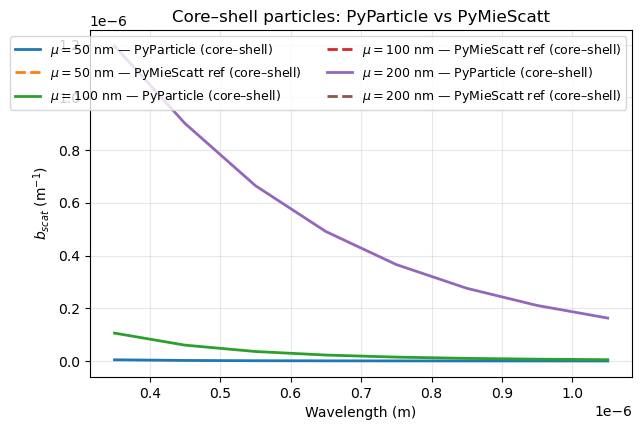

In [ ]:
# Core–shell companion: PyParticle b_scat vs PyMieScatt reference
import numpy as np
import matplotlib.pyplot as plt

from PyParticle.population.builder import build_population
from PyParticle.analysis.population.factory import b_scat as _bscat
from PyParticle.adapters.pymiescatt_ref import pymiescatt_core_shell_optics

# --- Grids (meters) ---
wvl_grid = np.linspace(350e-9,1050e-9,8)
rh_grid  = [0.0]

fig, ax = plt.subplots(figsize=(7, 4.5))

for item in series:
    pop_cfg = item['pop_cfg']
    label = item['label']
    _validate_pop_cfg(pop_cfg)
    pop = build_population(pop_cfg)
    var_cfg = {
        'morphology': 'core_shell',
        'rh_grid': rh_grid,
        'wvl_grid': wvl_grid,
        'T': 298.15,
        'species_modifications': pop_cfg.get('species_modifications', {}),
    }
    b_pkg = np.asarray(_bscat.build(var_cfg).compute(pop), dtype=float).squeeze()

    try:
        wvl_nm, b_scat_ref, b_abs_ref = pymiescatt_core_shell_optics(pop_cfg, var_cfg)
    except Exception as e:
        raise RuntimeError('PyMieScatt core–shell adapter call failed; ensure PyMieScatt is installed and adapter is available') from e

    wvl_nm = np.asarray(wvl_nm)
    b_scat_ref = np.asarray(b_scat_ref).squeeze()
    if wvl_nm.size != b_scat_ref.size:
        raise RuntimeError('Adapter returned mismatched wavelength and coefficient shapes')

    ax.plot(wvl_grid, b_pkg, label=f"{label} — PyParticle (core–shell)", lw=2.0)
    ax.plot(wvl_nm * 1e-9, b_scat_ref, '--', lw=2.0, label=f"{label} — PyMieScatt ref (core–shell)")

ax.set_xlabel("Wavelength (m)")
ax.set_ylabel(r"$b_{scat}$ (m$^{-1}$)")
ax.set_title("Core–shell particles: PyParticle vs PyMieScatt")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.show()

# Tip: For a more physically meaningful core–shell demo, use a population that includes a BC core
# (e.g., species ['BC','SO4'] with a nonzero BC fraction); otherwise homogeneous and core–shell may be identical.